# Sea Ice Thickness Figures

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import matplotlib.path as mpath
import xarray as xr
import cf_xarray
import cmocean as cm

In [2]:
# Import the data (names generalised to use for both comparisons)

data_1 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/ice_thickness_map_anom_Pan005.nc', chunks = 'auto')
data_2 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/ice_thickness_map_anom_Pan01.nc', chunks = 'auto')

In [3]:
# Land and contour data
shelf_contour_1 = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')['contour_masked_above']
shelf_contour_2 = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc')['contour_masked_above']

depth_1 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask_1 = (0 * depth_1).fillna(1)
land_1 = xr.where(np.isnan(depth_1.rename('land_1')), 1, np.nan)

depth_2 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_static.nc')['deptho']
land_mask_2 = (0 * depth_2).fillna(1)
land_2 = xr.where(np.isnan(depth_2.rename('land_2')), 1, np.nan)

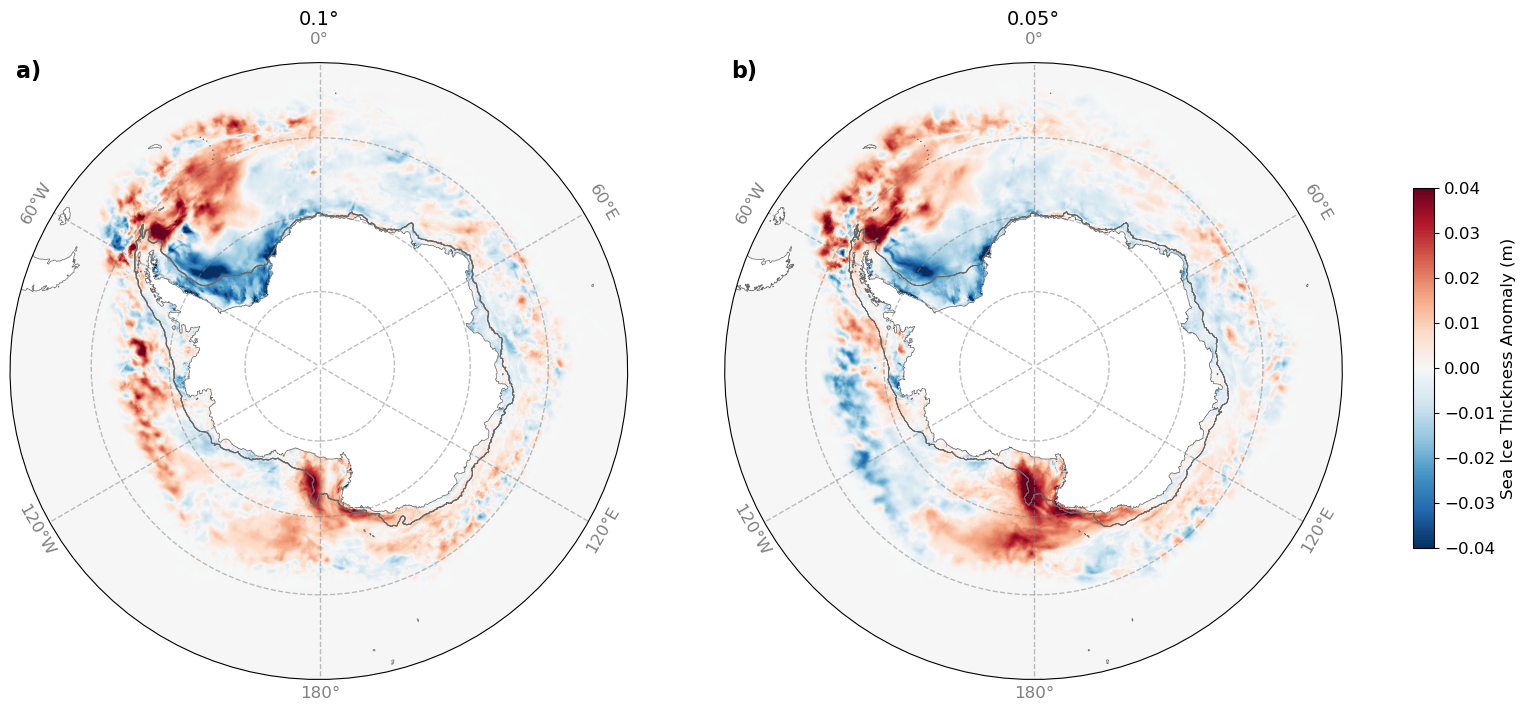

In [8]:
plt.rcParams['font.size'] = 16

# Projection
projection = ccrs.SouthPolarStereo()

# Figure with 2 subplots side by side
fig, axes = plt.subplots(
    nrows=1, ncols=2,
    subplot_kw={"projection": projection},
    figsize=(16, 7),
    constrained_layout=True
)

# Shared circle boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Datasets, land masks, shelf masks, and titles
datasets = [data_1, data_2] 
land_masks = [land_1, land_2]
land_contours = [land_mask_1, land_mask_2]
shelf_masks = [shelf_contour_1, shelf_contour_2]
titles = ["0.1°", "0.05°"]

# Longitude label settings for rotation
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W']
rot_lon = [0, 0, -60, -60, 60, 60]
lat_lon_label = [-48, -48, -48, -48, -48, -48]

# Loop over subplots
for i, (ax, data, land_m, land_contour, shelf_m, title) in enumerate(zip(
        axes, datasets, land_masks, land_contours, shelf_masks, titles)):

    ax.set_extent([-280, 80, -80, -50], crs=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)

    # Filled land
    land_m.plot.contourf(ax=ax, colors='white',
                         zorder=2, transform=ccrs.PlateCarree(),
                         add_colorbar=False)

    # Coast line
    ax.contour(land_contour.cf['X'], land_contour.cf['Y'], land_contour,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Shelf contour
    ax.contour(shelf_m.cf['X'], shelf_m.cf['Y'], shelf_m,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Gridlines (keep as in original plot)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, xlocs=range(-180, 171, 60), ylocs=[],
                      color='gray', alpha=0.5, linestyle='--', zorder=10)
    gl2 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                       linewidth=1, xlocs=[], ylocs=(-80, -70, -60),
                       color='gray', alpha=0.5, linestyle='--', zorder=10)

    # Manually rotate longitude labels
    for j, position in enumerate([0, 180, 60, -120, 120, -60]):
        ax.text(position, lat_lon_label[j], label_lon[j], rotation=rot_lon[j],
                ha='center', va='center', color='gray', fontsize=12,
                transform=ccrs.PlateCarree())

    # Plot dataset
    im = data.plot(
        x="xh", y="yh",
        transform=ccrs.PlateCarree(),
        vmin=-0.04, vmax=0.04,
        extend="both",
        cmap=plt.get_cmap('RdBu').reversed(),
        add_colorbar=False,
        ax=ax,
    )

    # Set title
    ax.set_title(title, fontsize=14, pad=25)

    # Add subplot label (a), (b), etc.
    ax.text(0.01,1, f'{chr(97+i)})', transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left', color='black')


# Smaller shared colorbar on the right
cbar = fig.colorbar(
    im, ax=axes, orientation="vertical",
    fraction=0.015,  # smaller width
    aspect=17,       # longer and thinner
    shrink=0.8, pad=0.05
)
cbar.set_label("Sea Ice Thickness Anomaly (m)", fontsize=12)
cbar.ax.tick_params(labelsize=12)  # tick font size

plt.show()

fig.savefig("/g/data/g40/kc5856/thesis_figures/resolution_seaicethickness_maps.png", dpi=300, bbox_inches='tight')

# Time series

In [18]:
# Bottom temp
data_1_time = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/ice_thickness_seasonal_time_anom_Pan01.nc', chunks = 'auto')
data_2_time = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/ice_thickness_seasonal_time_anom_Pan005.nc', chunks = 'auto')

In [25]:
data_1_time_new = data_1_time.to_series()
data_2_time_new = data_2_time.to_series()

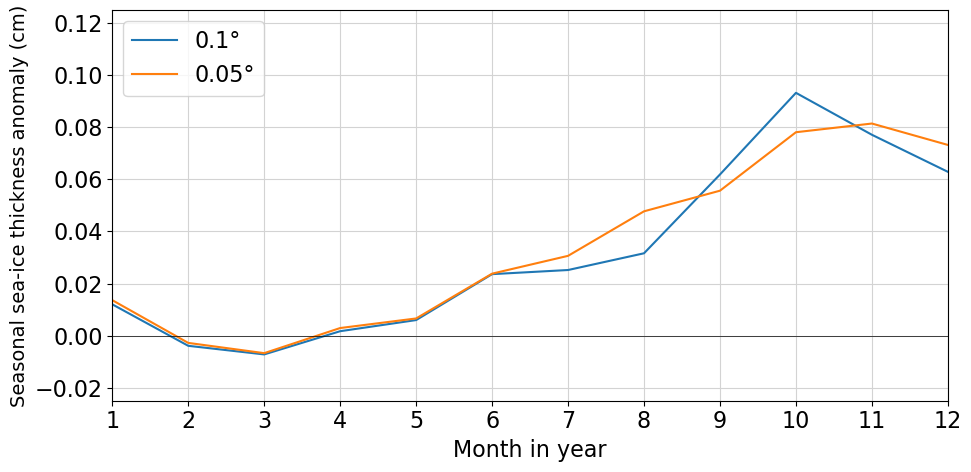

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(data_1_time_new.index, data_1_time_new.values * 100, label='0.1°')
plt.plot(data_2_time_new.index, data_2_time_new.values * 100, label='0.05°')

plt.xlabel('Month in year')
plt.ylabel("Seasonal sea-ice thickness anomaly (cm)", fontsize = 14)
plt.ylim(-0.025, 0.125)  # rescaled by factor of 100
plt.xlim(1, 12)
plt.xticks(range(1, 13))
plt.legend(loc='upper left')
plt.grid(True, color='lightgrey')
plt.axhline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()


# Combining

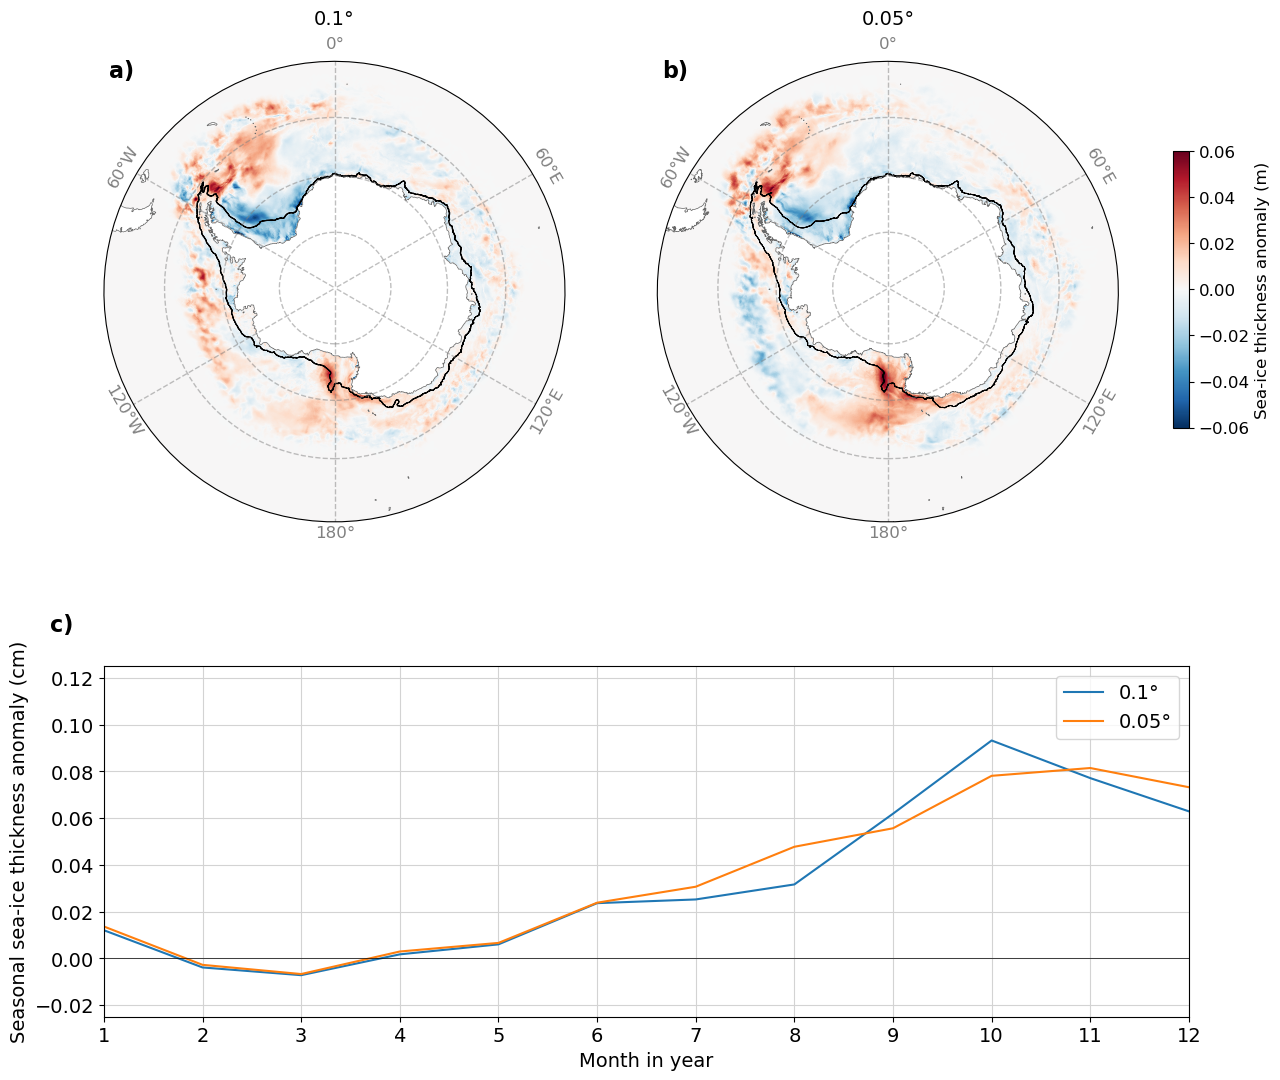

In [41]:
plt.rcParams['font.size'] = 14

# Projection
projection = ccrs.SouthPolarStereo()

# ---- FIGURE LAYOUT ----
fig = plt.figure(figsize=(14, 14))  # taller to fit timeseries
gs = fig.add_gridspec(2, 2, height_ratios=[1.2, 0.6], hspace=0.05)

# Top row: 2 map subplots
ax_map1 = fig.add_subplot(gs[0,0], projection=projection)
ax_map2 = fig.add_subplot(gs[0,1], projection=projection)
axes_maps = [ax_map1, ax_map2]

# Bottom row: 1 time series spanning both columns
ax_ts = fig.add_subplot(gs[1,:])

# ---- SHARED CIRCLE BOUNDARY FOR MAPS ----
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# ---- MAP PLOTTING (your existing loop) ----
datasets = [data_1, data_2] 
land_masks = [land_1, land_2]
land_contours = [land_mask_1, land_mask_2]
shelf_masks = [shelf_contour_1, shelf_contour_2]
titles = ["0.1°", "0.05°"]

label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W']
rot_lon   = [0, 0, -60, -60, 60, 60]
lat_lon_label = [-48, -48, -48, -48, -48, -48]

for i, (ax, data, land_m, land_contour, shelf_m, title) in enumerate(
    zip(axes_maps, datasets, land_masks, land_contours, shelf_masks, titles)):

    ax.set_extent([-280, 80, -80, -50], crs=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)

    # Land
    land_m.plot.contourf(ax=ax, colors='white', zorder=2,
                         transform=ccrs.PlateCarree(), add_colorbar=False)

    # Coastline
    ax.contour(land_contour.cf['X'], land_contour.cf['Y'], land_contour,
               levels=[0,1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Shelf
    ax.contour(shelf_m.cf['X'], shelf_m.cf['Y'], shelf_m,
               levels=[0,1], colors='black', linewidths=0.6,
               transform=ccrs.PlateCarree())

    # Gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, xlocs=range(-180, 171, 60), ylocs=[],
                      color='gray', alpha=0.5, linestyle='--', zorder=10)
    gl2 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                       linewidth=1, xlocs=[], ylocs=(-80,-70,-60),
                       color='gray', alpha=0.5, linestyle='--', zorder=10)

    # Manual lon labels
    for j, position in enumerate([0, 180, 60, -120, 120, -60]):
        ax.text(position, lat_lon_label[j], label_lon[j], rotation=rot_lon[j],
                ha='center', va='center', color='gray', fontsize=12,
                transform=ccrs.PlateCarree())

    # Data
    im = data.plot(
        x="xh", y="yh",
        transform=ccrs.PlateCarree(),
        vmin=-0.06, vmax=0.06,
        extend="both",
        cmap=plt.get_cmap('RdBu').reversed(),
        add_colorbar=False,
        ax=ax,
    )

    ax.set_title(title, fontsize=14, pad=25)

    # Labels (a), (b)
    ax.text(0.01,1, f'{chr(97+i)})', transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left', color='black')

# ---- COLORBAR (shared for maps) ----
cbar = fig.colorbar(
    im, ax=axes_maps, orientation="vertical",
    fraction=0.015, aspect=17, shrink=0.8, pad=0.05
)
cbar.set_label("Sea-ice thickness anomaly (m)", fontsize=12)
cbar.ax.tick_params(labelsize=12)

# ---- TIME SERIES PANEL (c) ----
plt.rcParams['font.size'] = 14

ax_ts.plot(data_1_time_new.index, data_1_time_new.values * 100, label='0.1°')
ax_ts.plot(data_2_time_new.index, data_2_time_new.values * 100, label='0.05°')

ax_ts.set_xlabel('Month in year')
ax_ts.set_ylabel("Seasonal sea-ice thickness anomaly (cm)", fontsize = 14)
ax_ts.set_ylim(-0.025, 0.125)  # rescaled by factor of 100
ax_ts.set_xlim(1, 12)
ax_ts.set_xticks(range(1, 13))
ax_ts.legend(loc='upper left')
ax_ts.grid(True, color='lightgrey')
ax_ts.axhline(0, color='black', linewidth=0.5)


# Label (c)
ax_ts.text(-0.05,1.15,"c)", transform=ax_ts.transAxes,
           fontsize=16, fontweight="bold", va="top", ha="left", color="black")

ax_ts.legend(loc="upper right")
ax_ts.grid(True, color="lightgrey")

# ---- SAVE ----
plt.show()
fig.savefig("/g/data/g40/kc5856/thesis_figures/resolution_seaicethickness_combined.png",
            dpi=300, bbox_inches="tight")
